In [99]:
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
from plancklens.sims import planck2018_sims, utils
import os
import healpy as hp
os.environ['PLENS'] = "/mnt/d/THESIS/PLENS"
os.environ['INPUT'] = "/mnt/d/THESIS/SIMS"
from tqdm import tqdm
from scipy import optimize

import plancklens
from plancklens import utils
from plancklens.sims import planck2018_sims, cmbs, phas, maps, utils as maps_utils


# hoef toch maar 2X CLs te berekenen
lmax = 4096
sims  = planck2018_sims.smica_dx12()

Using lenspyx alm2map


In [ ]:
# First, make the power spectra of sims by doing:
T_ave, Q_ave, U_ave = 0., 0., 0
Nsims = 300
for i in tqdm(range(Nsims)):
    T = sims.get_sim_tmap(i)
    Q, U = sims.get_sim_pmap(i)
    Tlm, Elm, Blm = hp.map2alm([T, Q, U], lmax=lmax)
    del T, Q, U
    hp.write_cl("/home/gilles/thesis/notebooks/dcls/sims_cltt%03d"%i, hp.alm2cl(Tlm))
    hp.write_cl("/home/gilles/thesis/notebooks/dcls/sims_clee%03d"%i, hp.alm2cl(Elm))
    hp.write_cl("/home/gilles/thesis/notebooks/dcls/sims_clbb%03d"%i, hp.alm2cl(Blm))
    del Tlm, Elm, Blm
del Q, U

 20%|██        | 61/300 [1:33:45<6:09:44, 92.82s/it]

In [ ]:
# Make alms for data
T_data = sims.get_dat_tmap()
Q_data, U_data = sims.get_dat_pmap()
Tlm, Elm, Blm = hp.map2alm([T_data, Q_data, U_data], lmax=lmax)
del T_data, Q_data, U_data
hp.write_alm("/home/gilles/thesis/notebooks/dcls/data_tlm", Tlm)
hp.write_alm("/home/gilles/thesis/notebooks/dcls/data_elm", Elm)
hp.write_alm("/home/gilles/thesis/notebooks/dcls/data_blm", Blm)
del Tlm, Elm, Blm

(80.0, 3000.0)

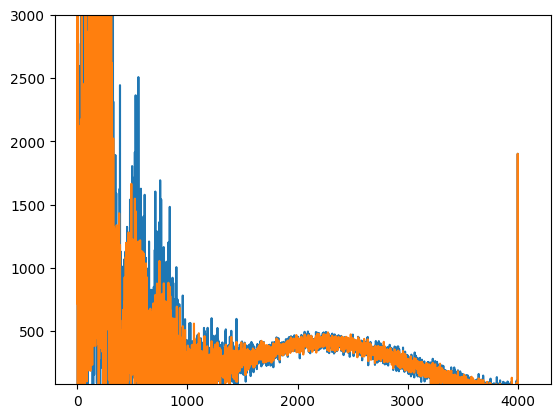

In [98]:
# Visualize the above for inspection
l = np.arange(lmax+1)
l *= l + 1

clTT_40 = hp.read_cl("/home/gilles/thesis/notebooks/dcls/sims_cltt040")
clTT_sims = 0
for i in range(60):
    clTT_sims += hp.read_cl("/home/gilles/thesis/notebooks/dcls/sims_cltt%03d"%i)/60

clTT_dat= hp.alm2cl(hp.read_alm("/home/gilles/thesis/notebooks/dcls/data_tlm"))


diff = clTT_sims-clTT_dat


plt.plot(np.abs(clTT_40-clTT_dat) * l)
plt.plot(np.abs(clTT_sims-clTT_dat) * l)
# plt.yscale("log")
plt.ylim([80, 3000])

6.066696922170763e-05 0.0012083344974705883 -3.0392784019557766 -6.172926531762522e-05


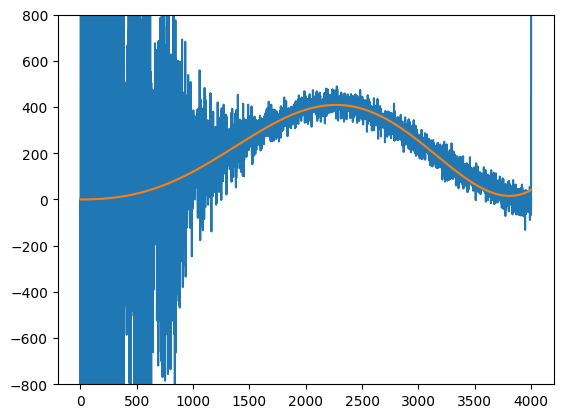

In [228]:
# Estimate the TT power spectrum dcl as a SINE func
def func_sin(x, a, b, c, d):
    return a*np.sin(b*x+c)+d

# Loading the power spectra of the data and averaged sims
clTT_sims = 0
for i in range(60):
    clTT_sims += hp.read_cl("/home/gilles/thesis/notebooks/dcls/sims_cltt%03d"%i)/60
clTT_dat= hp.alm2cl(hp.read_alm("/home/gilles/thesis/notebooks/dcls/data_tlm"))
diff =  clTT_sims - clTT_dat


l = np.arange(4000+1)
a, b, c, d = optimize.curve_fit(
    func_sin, l[1500:4000], diff[1500:4000], p0=[40, 0.0001, 1., 30])[0]

print(a, b, c, d)
dcl = func_sin(l, a, b, c, d)

# Some plotting to check results
plt.plot(-diff[:4001]*l**2)
plt.plot(-dcl*l**2)
plt.ylim([-800, 800])


dcl_TT_dat = np.zeros(dcl.shape)
dcl_TT_sim = -dcl

-4.2079084902228695e-10 3.7984566405661543e-05 2143.25175866712 8.130661193312218


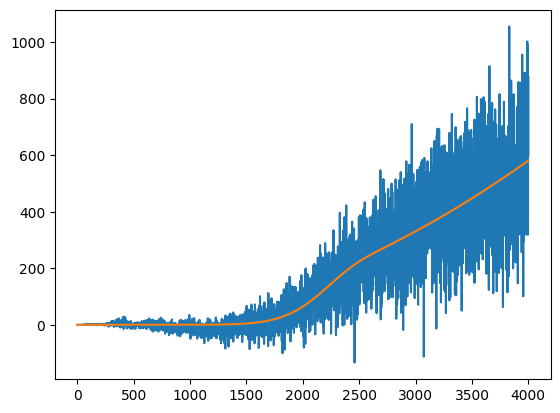

In [229]:
# Calculate the added noise for E and B modes
# Is estimated as a linear function, activated by a step function

def func_line(x, a, b):
    return a*x + b
def func_exp_step(x, a, b):
    return 1-np.exp(-(x/a)**b)
def func(x, a, b, c, d):
    return func_line(x, a, b) * func_exp_step(x, c, d)


# Loading the power spectra of the data and averaged sims
clEE_sims = 0
for i in range(60):
    clEE_sims += hp.read_cl("/home/gilles/thesis/notebooks/dcls/sims_clee%03d"%i)/60
clEE_dat= hp.alm2cl(hp.read_alm("/home/gilles/thesis/notebooks/dcls/data_elm"))
diff =  (clEE_sims - clEE_dat)[:4001]

l = np.arange(4001)

# Using scipy optimize to estimate parameters
a, b, c, d = optimize.curve_fit(
    func, l[2:4000], diff[2:4000], p0=[0.5, -100, 1000, 5.])[0]

print(a, b, c, d)
dcl = func(l, a, b, c, d)

plt.plot(diff*l**2)
plt.plot(dcl*l**2)

dcl_EE_dat = dcl
dcl_EE_sim = np.zeros(dcl.shape)

-9.688920762151197e-11 3.4052063177115807e-05 2055.2183959286026 7.506676674240391


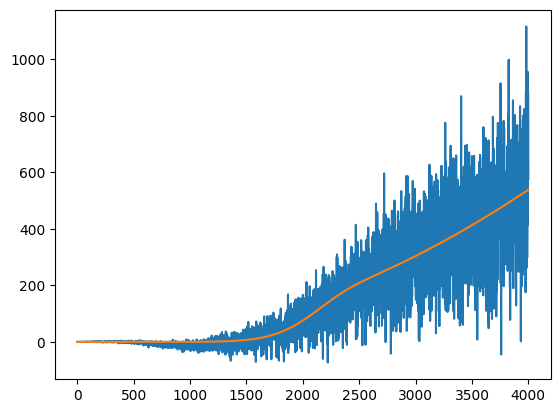

In [230]:

# Loading the power spectra of the data and averaged sims
clBB_sims = 0
for i in range(60):
    clBB_sims += hp.read_cl("/home/gilles/thesis/notebooks/dcls/sims_clbb%03d"%i)/60
clBB_dat= hp.alm2cl(hp.read_alm("/home/gilles/thesis/notebooks/dcls/data_blm"))
diff =  (clBB_sims - clBB_dat)[:4001]

l = np.arange(4001)

# Using scipy optimize to estimate parameters
a, b, c, d = optimize.curve_fit(
    func, l[2:4000], diff[2:4000], p0=[0.5, -100, 1000, 5])[0]

print(a, b, c, d)
dcl = func(l, a, b, c, d)

plt.plot(diff*l**2)
plt.plot(dcl*l**2)

dcl_BB_dat = dcl
dcl_BB_sim = np.zeros(dcl.shape)

In [231]:
# Save total in np.text, because it is loaded with such as
dcl_sim = [dcl_TT_sim, dcl_EE_sim, dcl_BB_sim]
dcl_dat = [dcl_TT_dat, dcl_EE_dat, dcl_BB_dat]


np.savetxt("/home/gilles/thesis/notebooks/input/dcl_sim", np.array(dcl_sim))
np.savetxt("/home/gilles/thesis/notebooks/input/dcl_dat", np.array(dcl_dat))


In [248]:
# Finally, a test to confirm if it works correctly

lmax_ivf = 4000
nside = 2048
nsims = 300
TEMP =  '/home/gilles/thesis/notebooks/dcls'
libdir_dclphas = os.path.join(TEMP, 'dcl_phas')

transf = hp.gauss_beam(5. / 60. / 180. * np.pi, lmax=lmax_ivf) * hp.pixwin(nside)[:lmax_ivf + 1]
dcl_phas = phas.lib_phas(libdir_dclphas, 3, lmax_ivf)
dcl = np.loadtxt("/home/gilles/thesis/notebooks/input/dcl_sim")[:, :lmax_ivf+1]* utils.cli(transf)**2
dcl_dat = np.loadtxt("/home/gilles/thesis/notebooks/input/dcl_dat")[:, :lmax_ivf+1]* utils.cli(transf)**2

sims_raw  = planck2018_sims.smica_dx12()
sims_dcl_sim = maps.cmb_maps_noisefree(cmbs.sims_cmb_unl({'tt':dcl[0], 'ee':dcl[1], 'bb':dcl[2]}, dcl_phas), transf)
sims_dcl_dat = maps_utils.sim_lib_shuffle(maps.cmb_maps_noisefree(cmbs.sims_cmb_unl({'tt':dcl_dat[0], 'ee':dcl_dat[1], 'bb':dcl_dat[2]}, dcl_phas), transf), {-1:nsims})
sims = maps_utils.sim_lib_add_dat([maps_utils.sim_lib_add_sim([sims_raw, sims_dcl_sim]), sims_dcl_dat])

T = sims.get_sim_tmap(0)
Q, U = sims.get_sim_pmap(0)
Tlm, Elm, Blm = hp.map2alm([T, Q, U], lmax = lmax_ivf)

hp.write_cl(os.path.join(TEMP, 'cltt_sim_test'), hp.alm2cl(Tlm), overwrite=True)
hp.write_cl(os.path.join(TEMP, 'clee_sim_test'), hp.alm2cl(Elm), overwrite=True)
hp.write_cl(os.path.join(TEMP, 'clbb_sim_test'), hp.alm2cl(Blm), overwrite=True)
del T, Q, U, Tlm, Elm, Blm

T = sims.get_sim_tmap(-1)
Q, U = sims.get_sim_pmap(-1)
Tlm, Elm, Blm = hp.map2alm([T, Q, U], lmax = lmax_ivf)

hp.write_cl(os.path.join(TEMP, 'cltt_dat_test'), hp.alm2cl(Tlm), overwrite=True)
hp.write_cl(os.path.join(TEMP, 'clee_dat_test'), hp.alm2cl(Elm), overwrite=True)
hp.write_cl(os.path.join(TEMP, 'clbb_dat_test'), hp.alm2cl(Blm), overwrite=True)

(1500.0, 4000.0)

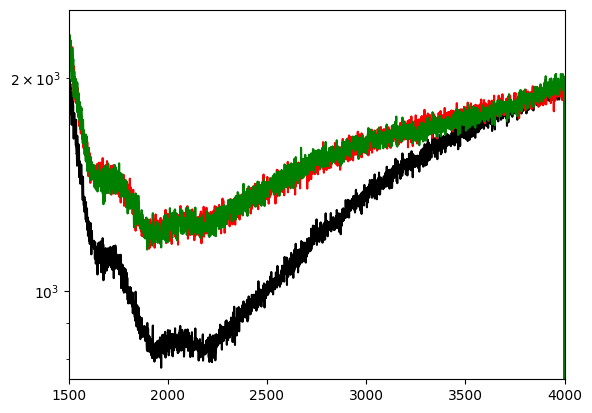

In [249]:
l = np.arange(lmax_ivf+1)

cl_sim = hp.read_cl(os.path.join(TEMP, 'cltt_sim_test'))*l**2
cl_dat = hp.read_cl(os.path.join(TEMP, 'cltt_dat_test'))*l**2
cl_old = hp.read_cl(os.path.join(TEMP, 'sims_cltt000'))[:4000+1]*l**2


plt.plot(cl_old, "k")
plt.plot(cl_dat, "r")
plt.plot(cl_sim, "g")
plt.yscale("log")
plt.ylim([750,2500])
plt.xlim([1500, lmax_ivf])